In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
import math
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)

In [3]:
def delta_schedule(n):
    ### Definition : 
    # Δₙ : la marge de confiance nécessaire pour inférer un label sans l’oracle.
    # Dans A², Δₙ contrôle la confiance dans la comparaison des erreurs empiriques.

        # Si : |err_pos - err_neg| > Δₙ 
        #    alors l’algorithme considère que l’un des deux labels est très probablement correct.
        # Si la différence est trop faible, 
        #    alors il existe trop d’ambiguïté → requête à l’oracle.

    ### Fonction : 
    # Δₙ = sq_rt ( 1 / n) * 𝛿(n)
    # où δ(n) est une fonction décroissante 
    # ( d'habitude : 1 / sq_rt(n), c / sq_rt(n), sq_rt((log(n)) / n )
    # ici :  c / sq_rt(n) avec c = 0.1
        
    ### Interpretation:
    # Lorsque n est petit → Δₙ est grand 
    #   → l’algorithme préfère poser des questions à l’oracle.
    # Lorsque n augmente → Δₙ diminue 
    #   → l’algorithme devient plus confiant et infère plus de labels.
    
    return 0.1 / math.sqrt(n)


In [4]:
def prepare_data_for_A2(X, y, test_size=0.3, stream_seed=1):
    """
    OUTPUT : 
    X_stream : flux pour l’apprentissage actif (Données arrivant séquentiellement pour A²)
    X_pool : données candidates pour le flux (stream), utilisées pour l’apprentissage actif.
    X_test : données finales utilisées uniquement pour évaluer le classifieur appris.
    y_pool, y_test : labels correspondants.
    X_pool_arr, y_pool_arr : copies utiles pour des comparaisons externes.
    oracle : fonction simulant les "questions au professeur" (Donne le vrai label quand A² ne peut pas décider)


                    Données globales X
                             │
                             ▼
                      ┌────────────┐
                      │   X_pool   │  ← données candidates
                      └────────────┘
                            │
               ┌────────────┴─────────────┐
               ▼                          ▼
           X_stream                       X_test
      (flux pour A²)                    (jamais vu)

            A² lit X_stream 1 par 1 :
            - soit il infère             → ajoute à S
            - soit il demande à l’oracle → ajoute à T

    """

    ### STEP 0 :  Verifie données sont en bonnes format
    y = np.array(y)

    ### STEP 1 : Séparation pool/test 
    # Dans l’apprentissage actif, il n’y a pas de X_train au départ.
    # Le modèle construit progressivement son ensemble d’entraînement en choisissant des points dans X_pool
    # (stratify=y garantit que les proportions des classes sont respectées)
    X_pool, X_test, y_pool, y_test = train_test_split( X, y, test_size=test_size, random_state=42, stratify=y    )

    ### STEP 2 : Construction du flux de données (stream)
    # le flux dans lequel A² voit les points un par un
    rng = np.random.RandomState(stream_seed)
    indices = np.arange(len(X_pool))
    rng.shuffle(indices)                # mélange les indices
    X_stream = X_pool[indices]          # flux final (les données du pool dans un ordre aléatoire)

    ### STEP 3 : Conversion des labels du pool en {-1, +1}
    y_pool_mapped = np.where(y_pool == 0, -1, 1) # traduit les labels initiaux ( 0 1) en labels conformes à la théorie (-1 +1)

    ### STEP 4 : Copies utiles des tableaux (pour comparaisons)
    X_pool_arr = np.array(X_pool)
    y_pool_arr = np.array(y_pool)

    ### STEP 5 : 
    # L’oracle doit fournir le vrai label d’un point du flux lorsque A² le demande.
    # Pour cela, on crée une table de correspondance :
    #   clé : un point (transformé en tuple pour être hashable)  
    #   valeur : son label {−1, +1}

    pool_map = {tuple(x): label for x, label in zip(X_pool, y_pool_mapped)}

    def oracle(x):
        # Si A² ne peut pas décider entre +1 et −1 pour un point, il interroge l’oracle.
        # L’oracle retourne le vrai label à partir du dictionnaire pool_map.
        ## Le +1 par défaut est un choix de sécurité (mais rarement utilisé, car tous les points du flux appartiennent au pool)
        return pool_map.get(tuple(x), +1)

    return {
        "X_stream": X_stream,
        "X_test": X_test,
        "y_test": y_test,
        "X_pool_arr": X_pool_arr,
        "y_pool_arr": y_pool_arr,
        "oracle": oracle
    }

In [5]:
def plot_accuracy_vs_queries(X_stream, X_test, y_test, oracle, learner):
    accuracies = []
    queries = []
    S, T = [], []

    y_test_mapped = np.where(y_test == 0, -1, 1)

    for n, x_n in enumerate(X_stream, start=1):
        h_pos = learner.learn_H(S + [(x_n, +1)], T)
        h_neg = learner.learn_H(S + [(x_n, -1)], T)
        err_pos = learner.empirical_error(h_pos, S + T)
        err_neg = learner.empirical_error(h_neg, S + T)
        Delta = learner.delta_schedule(max(1, n - 1))

        inferred_label = None
        if err_neg - err_pos > Delta:
            inferred_label = +1
        elif err_pos - err_neg > Delta:
            inferred_label = -1

        if inferred_label is not None:
            S.append((x_n, inferred_label))
        else:
            y_n = oracle(x_n)
            T.append((x_n, y_n))

        # recalculer précision toutes les 10 requêtes
        if n % 10 == 0:
            h_final = learner.learn_H(S, T)
            preds = h_final.predict(X_test)
            acc = np.mean(preds == y_test_mapped)
            accuracies.append(acc)
            queries.append(len(T))

    plt.figure(figsize=(6,4))
    plt.plot(queries, accuracies, marker='o')
    plt.xlabel("Nombre de requêtes à l'oracle")
    plt.ylabel("Précision sur X_test")
    plt.title("Évolution de la précision vs nombre de requêtes")
    plt.grid(True)
    plt.show()


In [6]:
def plot_results(res, dataset_name):
    labels = ["A² Active", "Passive baseline"] + list(res["passive_classifiers"].keys())
    accs = [res["acc_active"], res["acc_passive"]] + list(res["passive_classifiers"].values())
    
    plt.figure(figsize=(7,4))
    plt.bar(labels, accs, color='skyblue')
    plt.ylabel("Test Accuracy")
    plt.title(f"{dataset_name} — Test Accuracy Comparison")
    plt.xticks(rotation=30)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [7]:
class A2ActiveLearner:
    """
    Données Internes:
    S : (x, y_hat)  ensemble des points étiquetés implicitement (labels inférés par l’algorithme ie ensemble des labels inférés, utilisés comme si l’oracle avait répondu).
    T : (x, y_true) ensemble des points étiquetés explicitement (requêtes au véritable oracle ie ensemble des labels réellement demandés à l’oracle).
    n_requetes_oracle : nombre total de requêtes à l’oracle.

    Données Externes:
    delta_schedule : Δₙ (fonction)  la marge de confiance nécessaire pour inférer un label sans l’oracle.
    learn_H :
    """
    
    def __init__(self, learn_H, delta_schedule):
        ## Données internes : 
        self.S = []
        self.T = []
        self.n_requetes_oracle = 0

        self.learn_H = learn_H
        self.delta_schedule = delta_schedule

    @staticmethod
    def empirical_error(h, dataset):
        if len(dataset) == 0:
            return 0.0
        X = np.array([x for (x, y) in dataset])
        y = np.array([y for (x, y) in dataset])
        preds = h.predict(X)
        return np.mean(preds != y)

    def algorithmA2(self, X_stream, oracle, verbose = False):
        self.S = []
        self.T = []
        n_infered = 0  # compteur labels inférés
        self.n_requetes_oracle = 0

        for n, x_n in enumerate(X_stream, start=1):
            ## STEP 1 : Calcul des deux hypothèses candidates
            # “Train h⁺ and h⁻ using candidate labels +1 and -1”

            # Pour chaque point x_n, vous construisez deux hypothèses :
            #   h_pos = hypothèse entraînée sur S ∪ T avec (x_n, +1) ajouté dans S,
            #   h_neg = hypothèse entraînée sur S ∪ T avec (x_n, −1) ajouté dans S.

            #h_pos = self.learn_H(self.S + [(x_n, +1)], self.T)
            #h_neg = self.learn_H(self.S + [(x_n, -1)], self.T)

            ## Création des hypothèses candidate
            #       ça ajout a S (x_n, y_hat) PUIS apprenant un classifieur
            h_learn_pos = self.S + [(x_n, +1)]
            h_learn_neg = self.S + [(x_n, -1)]
            
            h_pos = self.learn_H(h_learn_pos, self.T)
            h_neg = self.learn_H(h_learn_neg, self.T)


            ## STEP 2 : Erreurs empiriques associées
            # definition des "versions spaces" restreints ( ou en anglais : version space disagreement )
            err_pos = self.empirical_error(h_pos, self.S + self.T)
            err_neg = self.empirical_error(h_neg, self.S + self.T)

            ## STEP 3 : Calcul du seuil Delta Δₙ
            Delta = self.delta_schedule(max(1, n - 1))

            ## STEP 4 :  Décision d’inférence
            # “Infer the label if the difference in empirical errors exceeds the threshold; otherwise query.”
            inferred_label = None

            # Si err_neg - err_pos > Δ ⇒ label inféré = +1
            if err_neg - err_pos > Delta:
                inferred_label = +1

            # Si err_pos - err_neg > Δ ⇒ label inféré = −1
            elif err_pos - err_neg > Delta:
                inferred_label = -1

            # Sinon ⇒ requête à l’oracle

            ## STEP 5 : Mise à jour (inférence ou requête)
            # Si le label est inféré, ajout dans S
            if inferred_label is not None:
                self.S.append((x_n, inferred_label))
                n_infered += 1

            # Sinon → interrogation de l'oracle et ajout dans T
            else:
                y_n = oracle(x_n)
                self.T.append((x_n, y_n))
                self.n_requetes_oracle += 1

            #  Affichage tous les 50 points
            if verbose and n % 50 == 0:  # affichage tous les 50 points
                print(f"Point {n}: inférés {n_infered}, oracle {self.n_requetes_oracle}")


            ## STEP 6 : Construction de l’hypothèse finale
            # apprenez un dernier classifieur h_final basé sur S ∪ T
        h_final = self.learn_H(self.S, self.T)
        return h_final, self.n_requetes_oracle



In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression

class SimpleClassifier:
    """
    Un classifieur générique pouvant fonctionner en :
    - mode constant (toujours prédire y = +1 ou -1),
    - mode logistic regression binaire normal.

    Gére les 3 cas (garantit que l’algorithme A² ne plante jamais): 
        - Pas de données    Retourne un modèle qui prédit +1 pour tout 
        - Une seule classe  Retourne un modèle constant qui prédit ce label 
        - Deux classes      Entraîne une logistic regression normale
    """
    def __init__(self, mode="constant", constant_value=1, clf=None):
        self.mode = mode                            # "constant" ou "logreg"
        self.constant_value = constant_value        # utilisé en mode constant
        self.clf = clf                              # logistic regression entraînée

    def predict(self, X):
        X = np.asarray(X)

        if self.mode == "constant":
            return np.full(len(X), self.constant_value, dtype=int)

        # Sinon => logistic regression
        preds = self.clf.predict(X)
        return np.where(preds == 0, -1, 1)


In [9]:
def learn_H_fn(S, T):
    """
    Gère les 3 cas :
        - S ∪ T = ∅
        - une seule classe
        - deux classes → logistic regression
    """
    
    ### STEP 1 : Fusion des données S et T (des listes de tuples (x, y)) pour avoir S ∪ T
    data = S + T

    ### STEP 2 : ## Cas 1 : aucune donnée disponible 
    # On ne peut pas entraîner un classifieur sans données, 
    # donc on renvoie donc un classifieur trivial qui prédit toujours +1.

    if len(data) == 0:
        return SimpleClassifier(mode="constant", constant_value=1)

    # Extraction X et y
    X = np.array([x for (x, y) in data])
    y = np.array([y for (x, y) in data])

    # Conversion des labels dans le format scikit-learn
    y_sklearn = np.where(y == -1, 0, 1)

    ## Cas 2 : une seule classe présente 
    # La régression logistique ne peut pas s’entraîner avec une seule classe. 
    # Donc si toutes les données portent le même label, 
    # on retourne un classifieur constant qui prédit ce label.
    unique = np.unique(y_sklearn)
    
    if len(unique) == 1:
        const_value = -1 if unique[0] == 0 else 1
        return SimpleClassifier(mode="constant", constant_value=const_value)

    ## Cas 3 : les deux classes sont présentes → apprentissage normal
    clf = LogisticRegression(max_iter=200, solver="liblinear")
    clf.fit(X, y_sklearn)

    return SimpleClassifier(mode="logreg", clf=clf)


In [10]:
def run_passive(X_pool, y_pool, n_queries, clf_class, **clf_kwargs):
    """Entraîne un classifieur passif choisi sur n_queries exemples du pool"""
    idx = np.random.choice(len(X_pool), size=n_queries, replace=False)
    X_train, y_train = X_pool[idx], y_pool[idx]
    y_train = np.where(y_train == 0, -1, y_train)
    
    clf = clf_class(**clf_kwargs)
    clf.fit(X_train, y_train)
    return clf

In [11]:
def run_passive_baseline(X_pool, y_pool, n_queries, learn_H):
    """
    Entraîne un modèle passif sur n_queries exemples tirés au hasard.
    Si n_queries = 0 → retourne un classifieur constant +1.
    """
    # STEP 0 : aucune requête → modèle trivial
    if n_queries == 0:
        return SimpleClassifier(mode="constant", constant_value=1)

    # STEP 1 : Sélection aléatoire de n_queries données
    idx = np.random.choice(len(X_pool), size=n_queries, replace=False)
    X_train = X_pool[idx]
    y_train = y_pool[idx]

    # STEP 2 : Remapping 0 → -1 si nécessaire
    y_train = np.where(y_train == 0, -1, y_train)

    # STEP 3 : Format (x, y)
    data = list(zip(X_train, y_train))

    # STEP 4 : Entraînement via learn_H
    model = learn_H(data, [])

    return model


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde


def plot_all_visualizations(X, y, learner=None, oracle_T=None, res=None, title="Visualisation complète A²"):
    """
    Produit une figure unique contenant 6 graphiques,
    tous construits à partir de X et y.
    
    - learner : modèle final du learner (pour visualiser erreurs)
    - oracle_T : liste des points consultés (pour marquage)
    """

    # -----------------------
    # 1) PCA UNIQUE
    # -----------------------
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
    else:
        X_vis = X.copy()

    # Oracle — repérage des indices
    oracle_indices = []
    if oracle_T is not None:
        for tx, _ in oracle_T:
            matches = np.where(np.all(X == tx, axis=1))[0]
            oracle_indices.extend(matches)


    # ---------------------------------------------------
    fig, axes = plt.subplots(3, 2, figsize=(13, 17))
    ax = axes.ravel()


    # ===================================================
    # 1) Points colorés selon label
    # ===================================================
    ax0 = ax[0]
    ax0.scatter(X_vis[:,0], X_vis[:,1], c=['red' if lab==0 else 'blue' for lab in y], s=20)
    ax0.set_title("1) Points colorés selon labels")
    ax0.grid(True)


    # ===================================================
    # 2) Visualisation des erreurs du learner
    # ===================================================
    ax1 = ax[1]
    if learner is not None:
        y_pred = learner.predict(X)
        correct = y_pred == np.where(y==0, -1, 1)
        ax1.scatter(X_vis[correct,0], X_vis[correct,1], c='green', s=20, label="Correct")
        ax1.scatter(X_vis[~correct,0], X_vis[~correct,1], c='red', s=40, label="Erreur")
        ax1.legend()
    else:
        ax1.text(0.5, 0.5, "Pas de learner fourni", ha='center')
    ax1.set_title("2) Erreurs du learner")
    ax1.grid(True)


    # ===================================================
    # 3) Points “difficiles” = petites marges SVM
    # ===================================================
    ax2 = ax[2]
    svm = SVC(kernel='linear').fit(X_vis, y)
    margins = np.abs(svm.decision_function(X_vis))
    idx_small = np.argsort(margins)[:30]
    ax2.scatter(X_vis[:,0], X_vis[:,1], c='gray', s=15)
    ax2.scatter(X_vis[idx_small,0], X_vis[idx_small,1], edgecolors='green',
                facecolors='none', s=80, label="Faible marge")
    ax2.legend()
    ax2.set_title("3) Points difficiles (faible marge SVM)")
    ax2.grid(True)


    # ===================================================
    # 4) Ordre de passage des points (X lui-même si flux=dataset)
    # ===================================================
    ax3 = ax[3]
    colors = plt.cm.viridis(np.linspace(0, 1, len(X_vis)))
    ax3.scatter(X_vis[:,0], X_vis[:,1], c=colors, s=25)
    ax3.set_title("4) Ordre de passage des données (index)")
    ax3.grid(True)


    # ===================================================
    # 5) Bar plot des accuracies
    # ===================================================
    ax[4].set_title("5) Test Accuracy Comparison")
    ax[4].grid(False)
    if res is not None:
        labels = ["A² Active", "Passive baseline"] + list(res["passive_classifiers"].keys())
        # Utiliser les metrics au lieu de acc_active / acc_passive
        accs = [res["metrics_active"]["accuracy"], res["metrics_passive"]["accuracy"]] \
            + [v["accuracy"] for v in res["passive_classifiers"].values()]
        ax[4].bar(labels, accs, color='skyblue')
        ax[4].set_ylim(0,1)
        ax[4].set_ylabel("Test Accuracy")
        ax[4].tick_params(axis='x', rotation=30)
    else:
        ax[4].text(0.5,0.5,"Pas de résultat fourni", ha='center')


    # ===================================================
    # 6) Heatmap + Outliers + A² queries (X,y bruts)
    # ===================================================
    ax6 = ax[5]  # le 6ème sous-graphique
    ax6.set_title("6) Heatmap + Outliers + A² Queries")
    ax6.grid(True)

    # Couleurs et colormap
    colors_map = ['Reds', 'Blues']
    class_colors = ['red', 'blue']

    # Heatmaps par classe et points
    heatmaps, points = [], []
    for label in np.unique(y):
        X_class = X_vis[y==label]
        kde = gaussian_kde(X_class.T)
        x_min, x_max = X_class[:,0].min()-1, X_class[:,0].max()+1
        y_min, y_max = X_class[:,1].min()-1, X_class[:,1].max()+1
        xx, yy = np.meshgrid(np.linspace(x_min,x_max,100), np.linspace(y_min,y_max,100))
        grid_coords = np.vstack([xx.ravel(), yy.ravel()])
        density = kde(grid_coords).reshape(xx.shape)
        ax6.contourf(xx, yy, density, levels=20, alpha=0.3, cmap=colors_map[label])
        heatmaps.append(Patch(color=plt.cm.get_cmap(colors_map[label])(0.6), label=f"Heatmap classe {label}"))

        # Points normaux
        ax6.scatter(X_class[:,0], X_class[:,1], c=class_colors[label], s=20)
        points.append(Line2D([0],[0], marker='o', color='w', label=f"Points classe {label}",
                            markerfacecolor=class_colors[label], markersize=7))

    # Outliers (5 par classe)
    outlier_handles = []
    for label in np.unique(y):
        X_class_full = X_vis[y==label]
        centroid = X_class_full.mean(axis=0)
        distances = np.linalg.norm(X_class_full - centroid, axis=1)
        out_idx = np.where(y==label)[0][np.argsort(distances)[-5:]]
        ax6.scatter(X_vis[out_idx,0], X_vis[out_idx,1], facecolors='none', edgecolors='black', s=100)
        outlier_handles.append(Line2D([0],[0], marker='o', color='w', label=f"Outliers classe {label}",
                                    markerfacecolor='none', markeredgecolor='black', markersize=10))

    # Points A² (SVM margin)
    svm = SVC(kernel='linear').fit(X_vis, y)
    distances = svm.decision_function(X_vis)
    n_queries = min(30, len(X_vis))
    interesting_indices = np.argsort(np.abs(distances))[:n_queries]
    ax6.scatter(X_vis[interesting_indices,0], X_vis[interesting_indices,1],
                facecolors='none', edgecolors='green', s=100)
    a2_legend = [Line2D([0],[0], marker='o', color='w', label='A² query',
                        markerfacecolor='none', markeredgecolor='green', markersize=10)]

    # Légende complète
    ax6.legend(handles=heatmaps + points + outlier_handles + a2_legend,
            bbox_to_anchor=(1.05,1), loc='upper left')

    


    # ---------------------------------------------------
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [13]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def run_experiment(X, y, test_size=0.3, stream_seed=1):
    
    data = prepare_data_for_A2(X, y, test_size, stream_seed)

    X_stream = data["X_stream"]
    X_test = data["X_test"]
    y_test = data["y_test"]
    X_pool_arr = data["X_pool_arr"]
    y_pool_arr = data["y_pool_arr"]
    oracle = data["oracle"]

    active = A2ActiveLearner(learn_H_fn, delta_schedule)
    h_active, n_requetes_oracle = active.algorithmA2(X_stream, oracle, True)

    # ------------------------
    # Définition des classifieurs passifs
    # ------------------------
    passive_classifiers = {
        "Naive Bayes": GaussianNB,
        "kNN": lambda: KNeighborsClassifier(n_neighbors=5),
        "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=0),
        "SVM": lambda: SVC(kernel='linear', C=1.0),
        "Logistic Regression": lambda: LogisticRegression(max_iter=200, solver='liblinear')
    }

    passive_results = {}
    for name, clf_fn in passive_classifiers.items():
        X_train = X_pool_arr
        y_train_mapped = np.where(y_pool_arr == 0, -1, y_pool_arr)

        clf = clf_fn() if callable(clf_fn) else clf_fn
        clf.fit(X_train, y_train_mapped)
        preds = clf.predict(X_test)
        passive_results[name] = {
            "accuracy": accuracy_score(np.where(y_test==0,-1,y_test), preds),
            "recall": recall_score(np.where(y_test==0,-1,y_test), preds),
            "f1": f1_score(np.where(y_test==0,-1,y_test), preds)
        }


    # Accuracies et métriques pour actif
    y_test_mapped = np.where(y_test==0, -1, y_test)
    preds_active = h_active.predict(X_test)
    metrics_active = {
        "accuracy": accuracy_score(y_test_mapped, preds_active),
        "recall": recall_score(y_test_mapped, preds_active),
        "f1": f1_score(y_test_mapped, preds_active)
    }

    # Meilleur classifieur passif
    best_passive_name = max(passive_results, key=lambda k: passive_results[k]["accuracy"])
    metrics_passive = passive_results[best_passive_name]

    # Créer le dictionnaire res complet
    res = {
        "metrics_active": metrics_active,
        "metrics_passive": metrics_passive,
        "best_passive": best_passive_name,
        "queries": n_requetes_oracle,
        "n_pool": len(X_pool_arr),
        "n_test": len(X_test),
        "passive_classifiers": passive_results
    }

    # ------------------------
    # Affichage de tous les graphiques
    # ------------------------
    plot_all_visualizations(X, y, learner=h_active, oracle_T=active.T, res=res)

    return res


## Création de données synthétiques:

In [14]:
from sklearn.datasets import make_classification

# Paramètres variés pour chaque dataset
dataset_params = [
    {"name": "Easy", "n_features": 5, "n_informative": 5, "n_redundant":0, "flip_y":0.0, "class_sep":2.5},
    {"name": "Medium", "n_features": 10, "n_informative": 6, "n_redundant":3, "flip_y":0.05, "class_sep":1.5},
    {"name": "Hard", "n_features": 20, "n_informative": 10, "n_redundant":5, "flip_y":0.1, "class_sep":1.0},
    {"name": "Noisy", "n_features": 15, "n_informative": 5, "n_redundant":5, "flip_y":0.2, "class_sep":1.0},
    {"name": "Separated", "n_features": 10, "n_informative": 8, "n_redundant":1, "flip_y":0.0, "class_sep":3.0},
]

datasets_syn = []

for params in dataset_params:
    X, y = make_classification(
        n_samples=600,
        n_features=params["n_features"],
        n_informative=params["n_informative"],
        n_redundant=params["n_redundant"],
        n_clusters_per_class=2,
        flip_y=params["flip_y"],
        class_sep=params["class_sep"],
        random_state=42
    )
    datasets_syn.append({"name": params["name"], "X": X, "y": y})

## Importation de dataset : breast cancer 

*(https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)*

In [15]:
datasets_real = []

# Breast Cancer (2 classes)
bc = load_breast_cancer()
datasets_real.append({
    "name": "BreastCancer",
    "X": bc.data,
    "y": bc.target
})

# Wine (filtré pour 2 classes)
wine = load_wine()
mask = wine.target != 2  # garder seulement classes 0 et 1
datasets_real.append({
    "name": "Wine",
    "X": wine.data[mask],
    "y": wine.target[mask]
})


# Base de donnée complète

In [16]:
datasets = datasets_syn + datasets_real

## Run les algos : A² et Passif


--- Running experiment on Easy ---
Point 50: inférés 11, oracle 39
Point 100: inférés 20, oracle 80
Point 150: inférés 23, oracle 127
Point 200: inférés 27, oracle 173
Point 250: inférés 28, oracle 222
Point 300: inférés 28, oracle 272
Point 350: inférés 31, oracle 319
Point 400: inférés 34, oracle 366


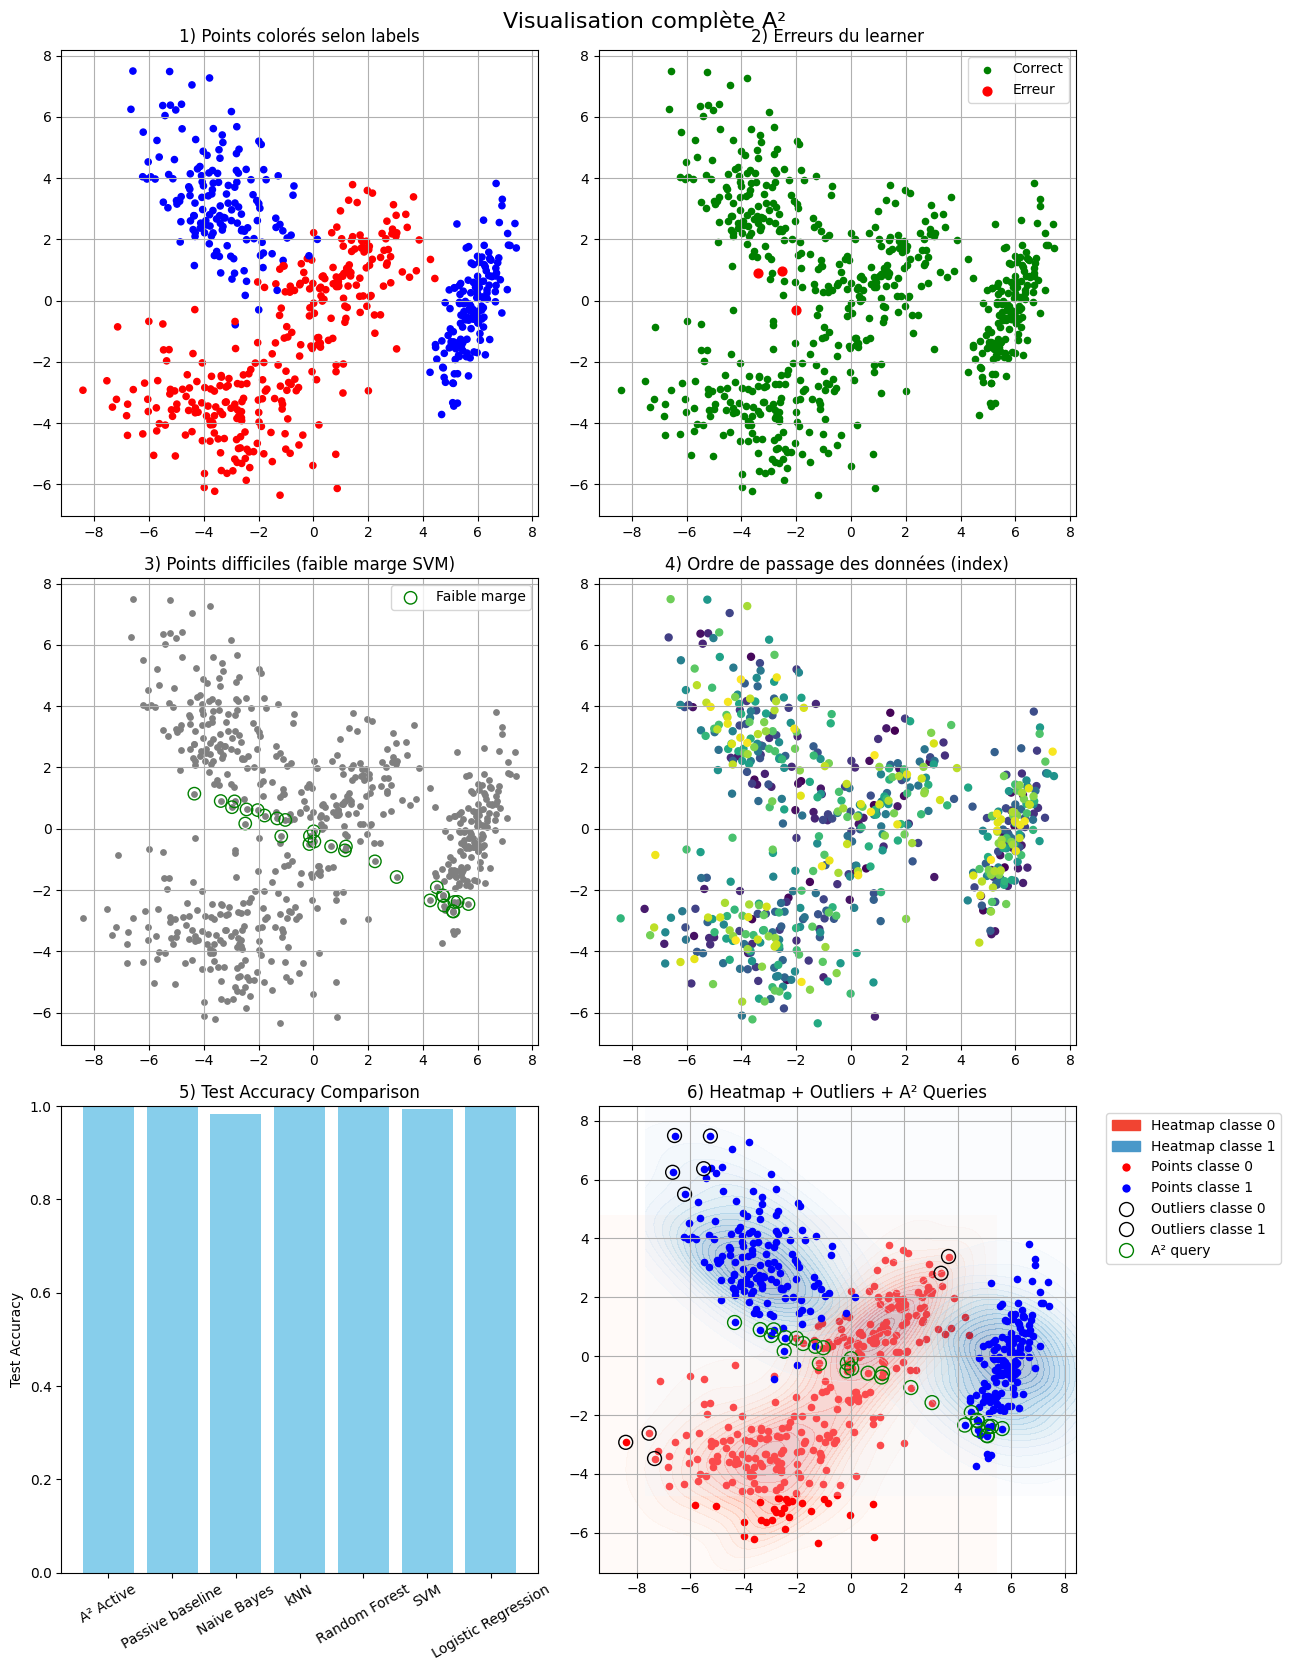


--- Running experiment on Medium ---
Point 50: inférés 6, oracle 44
Point 100: inférés 31, oracle 69
Point 150: inférés 57, oracle 93
Point 200: inférés 73, oracle 127
Point 250: inférés 85, oracle 165
Point 300: inférés 96, oracle 204
Point 350: inférés 110, oracle 240
Point 400: inférés 122, oracle 278


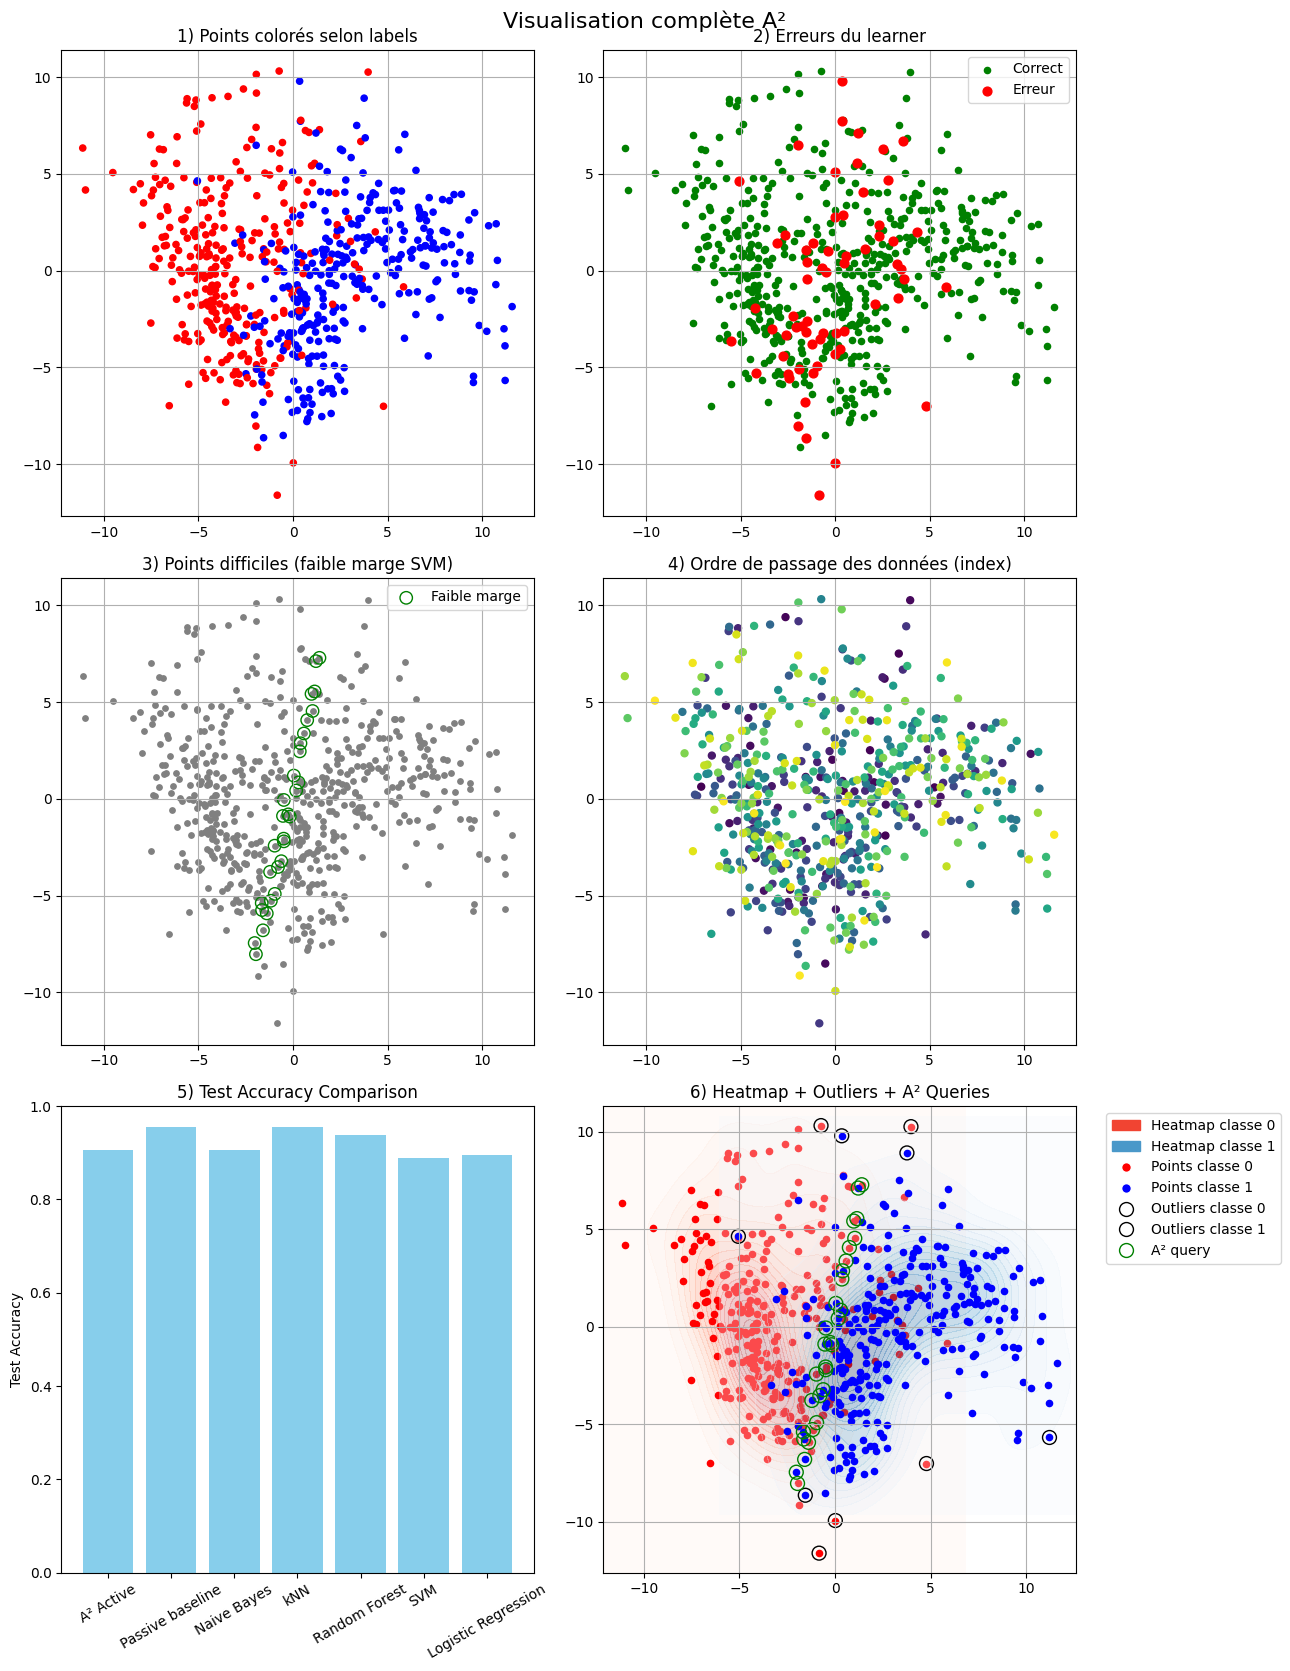


--- Running experiment on Hard ---
Point 50: inférés 19, oracle 31
Point 100: inférés 51, oracle 49
Point 150: inférés 76, oracle 74
Point 200: inférés 89, oracle 111
Point 250: inférés 121, oracle 129
Point 300: inférés 140, oracle 160
Point 350: inférés 168, oracle 182
Point 400: inférés 196, oracle 204


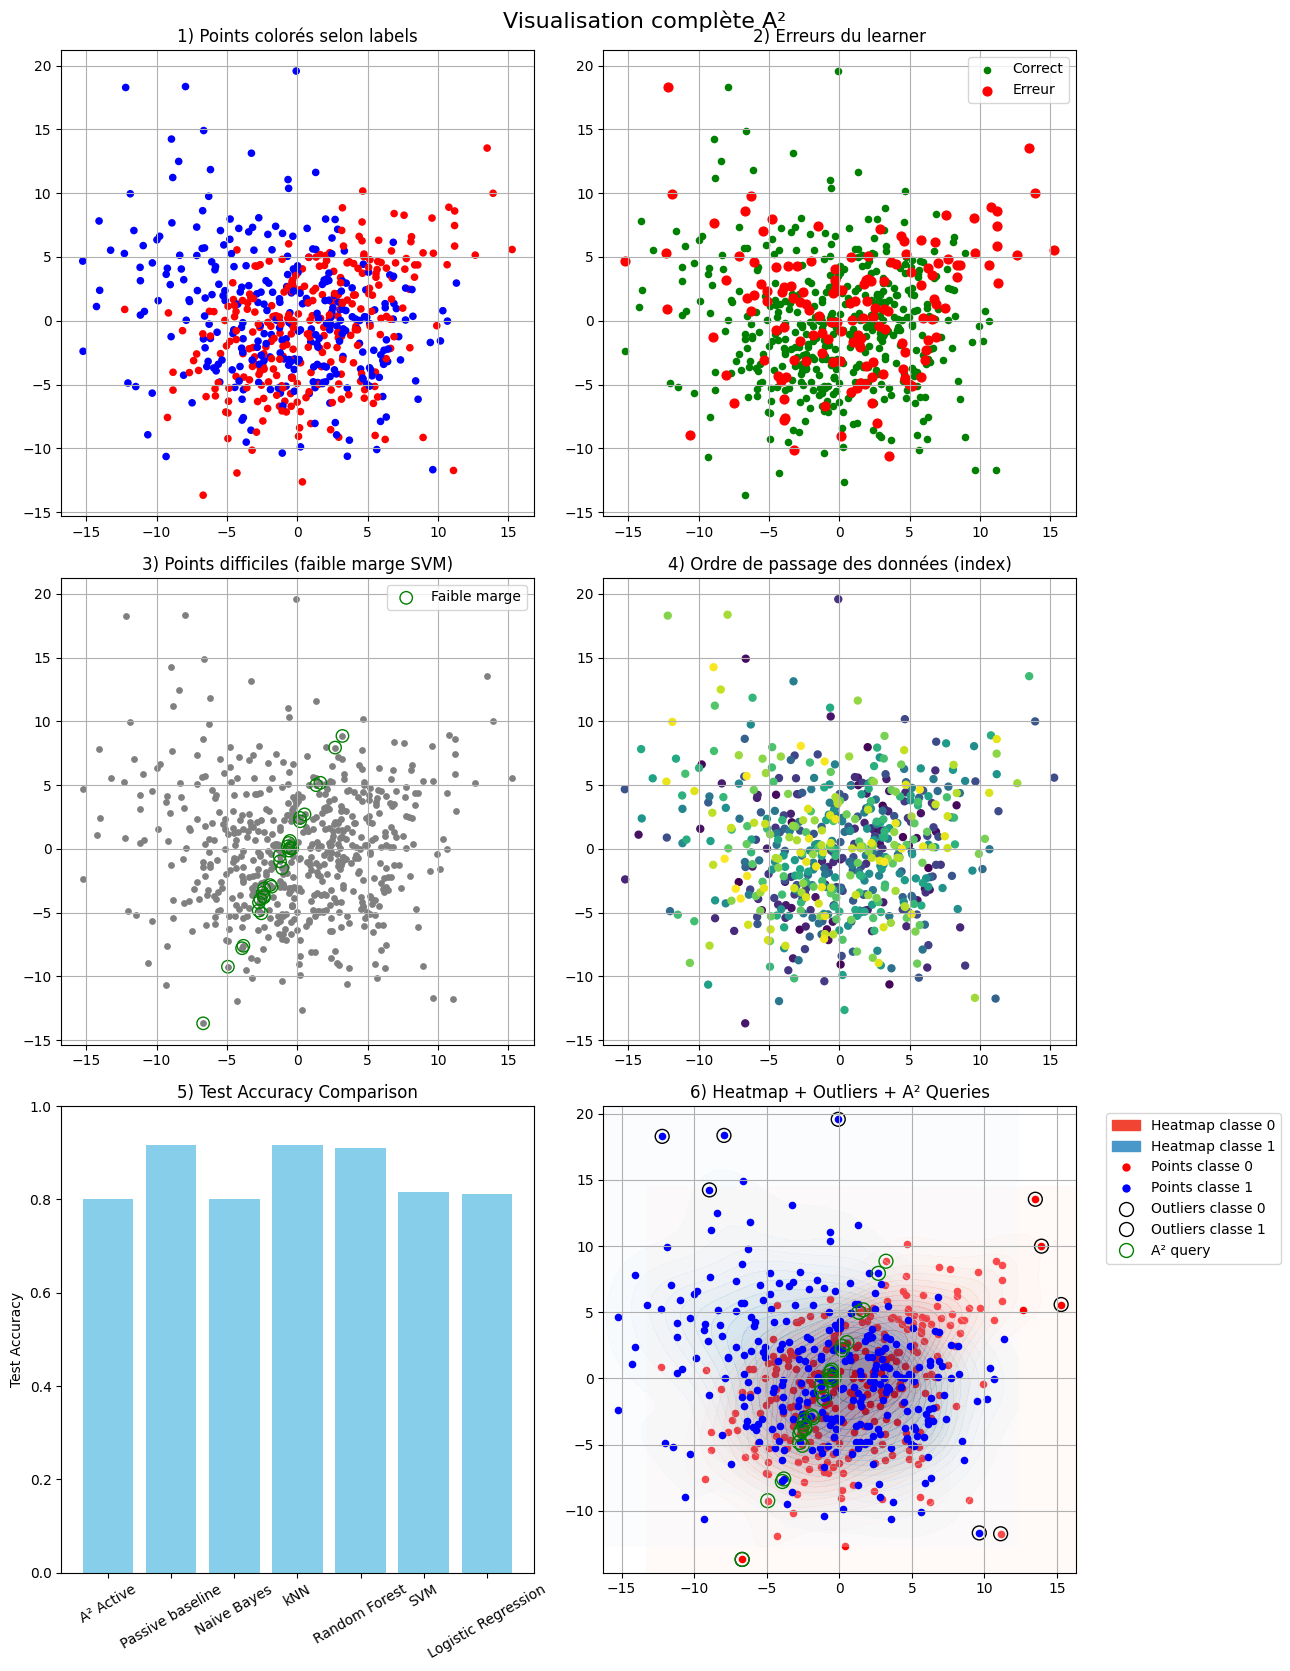


--- Running experiment on Noisy ---
Point 50: inférés 31, oracle 19
Point 100: inférés 72, oracle 28
Point 150: inférés 94, oracle 56
Point 200: inférés 114, oracle 86
Point 250: inférés 136, oracle 114
Point 300: inférés 167, oracle 133
Point 350: inférés 199, oracle 151
Point 400: inférés 227, oracle 173


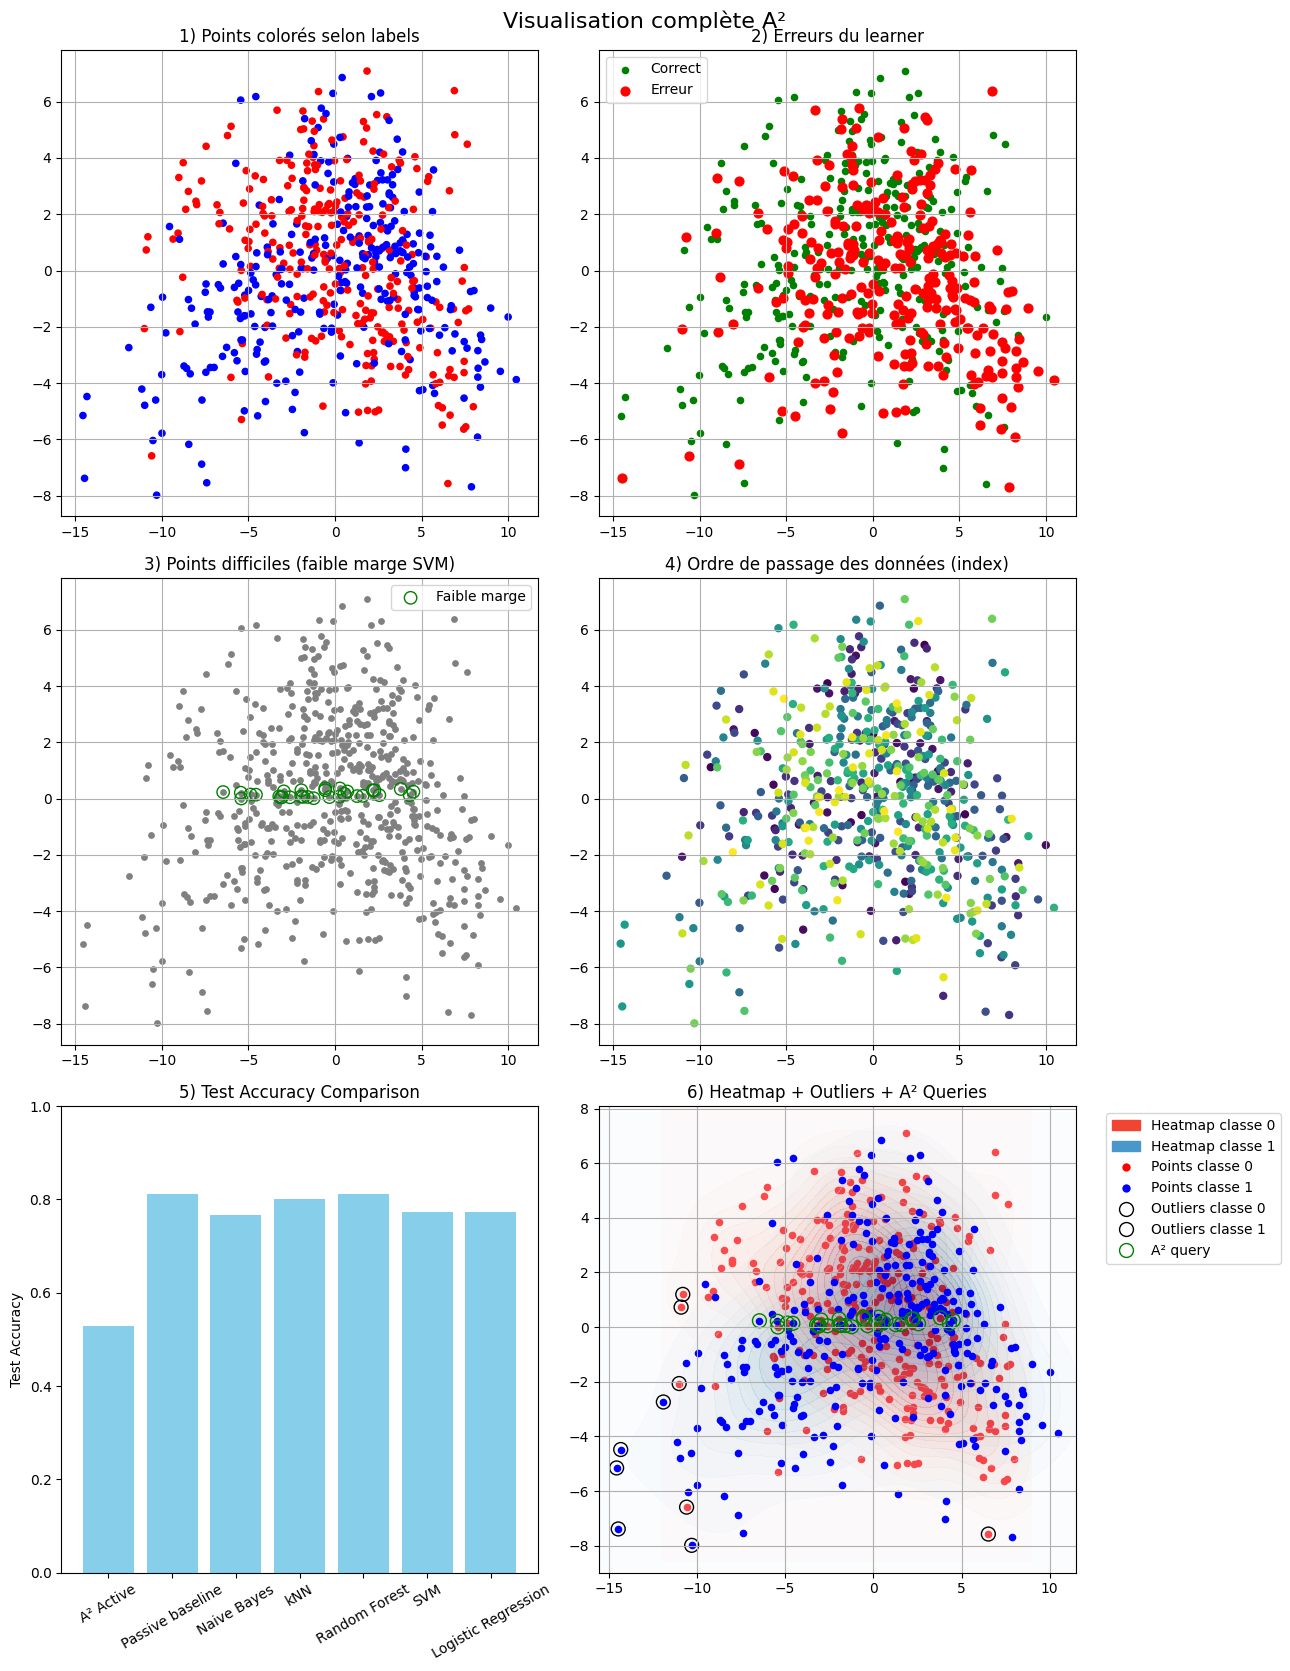


--- Running experiment on Separated ---
Point 50: inférés 9, oracle 41
Point 100: inférés 15, oracle 85
Point 150: inférés 16, oracle 134
Point 200: inférés 21, oracle 179
Point 250: inférés 25, oracle 225
Point 300: inférés 25, oracle 275
Point 350: inférés 25, oracle 325
Point 400: inférés 25, oracle 375


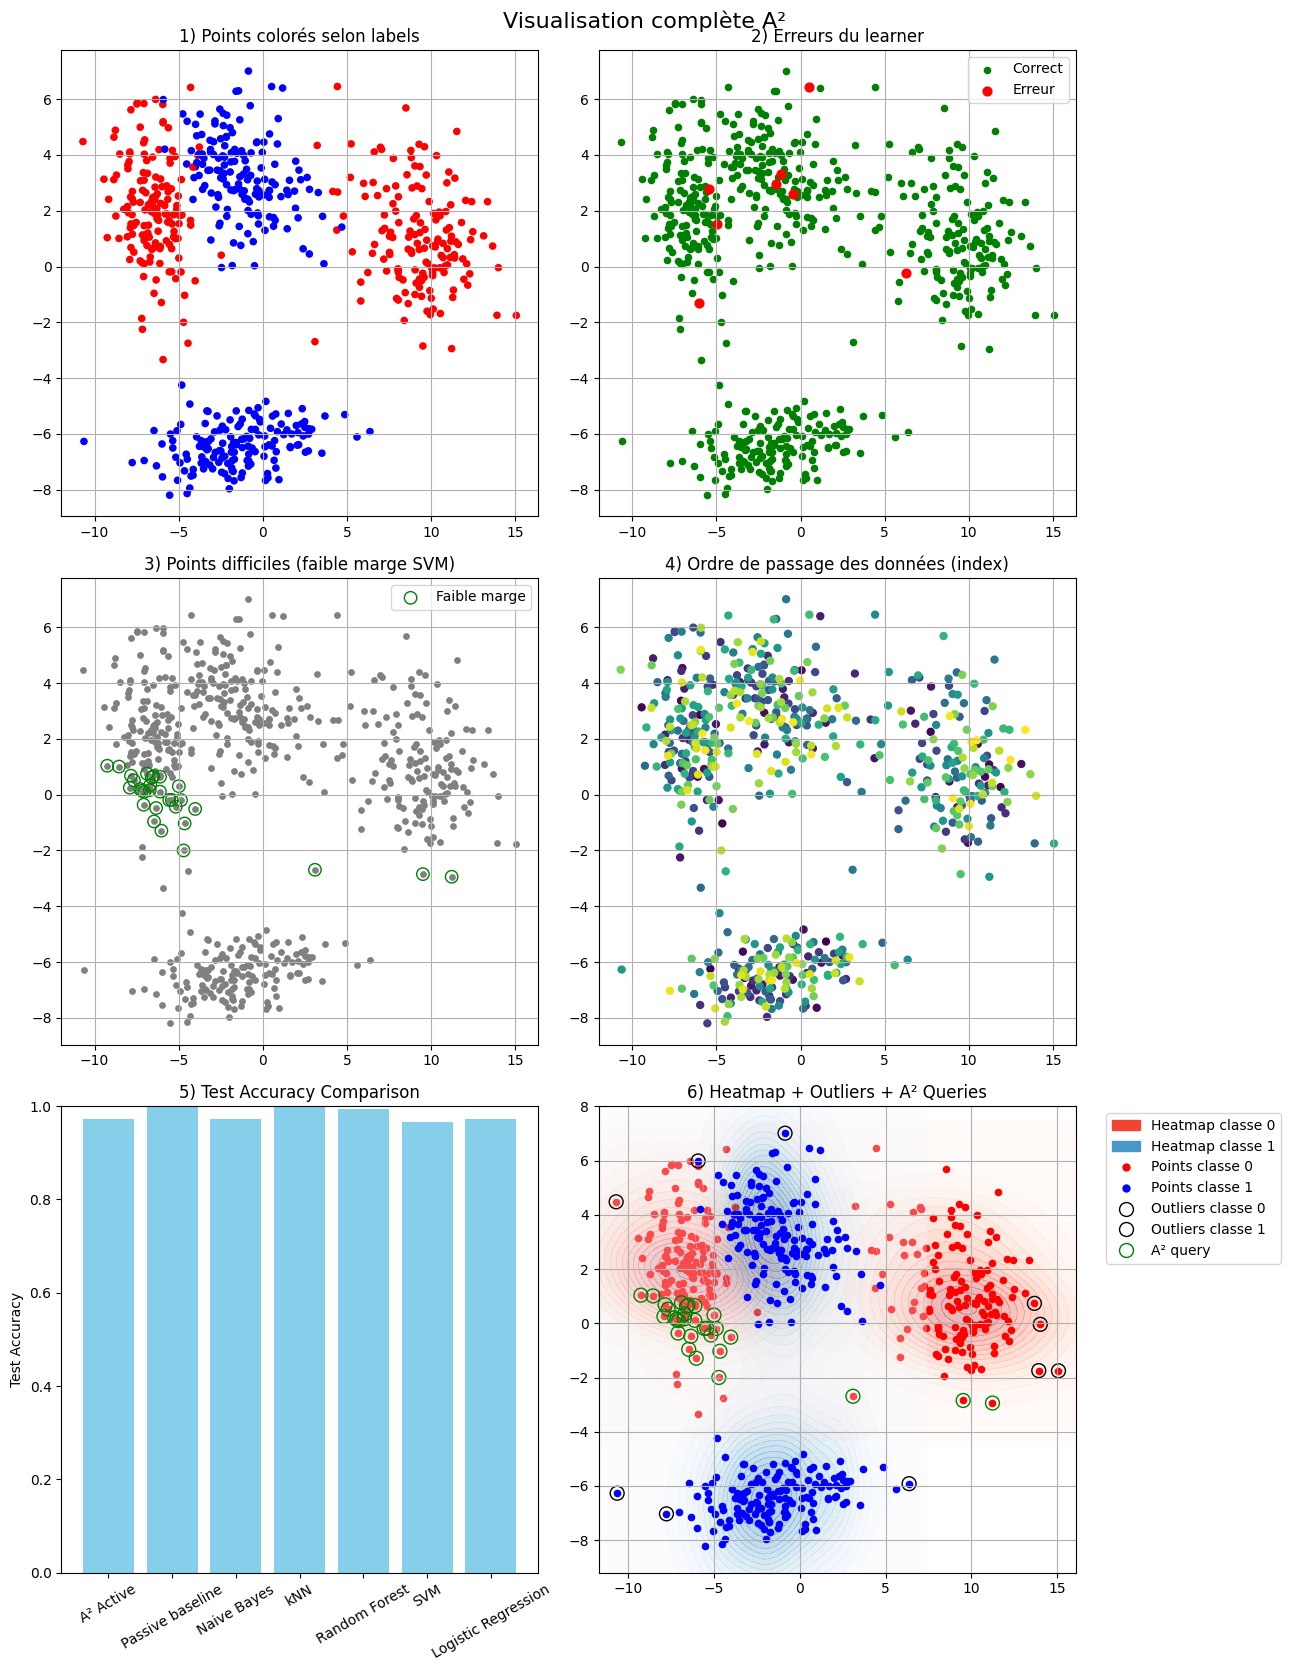


--- Running experiment on BreastCancer ---
Point 50: inférés 8, oracle 42
Point 100: inférés 25, oracle 75
Point 150: inférés 32, oracle 118
Point 200: inférés 43, oracle 157
Point 250: inférés 53, oracle 197
Point 300: inférés 57, oracle 243
Point 350: inférés 67, oracle 283


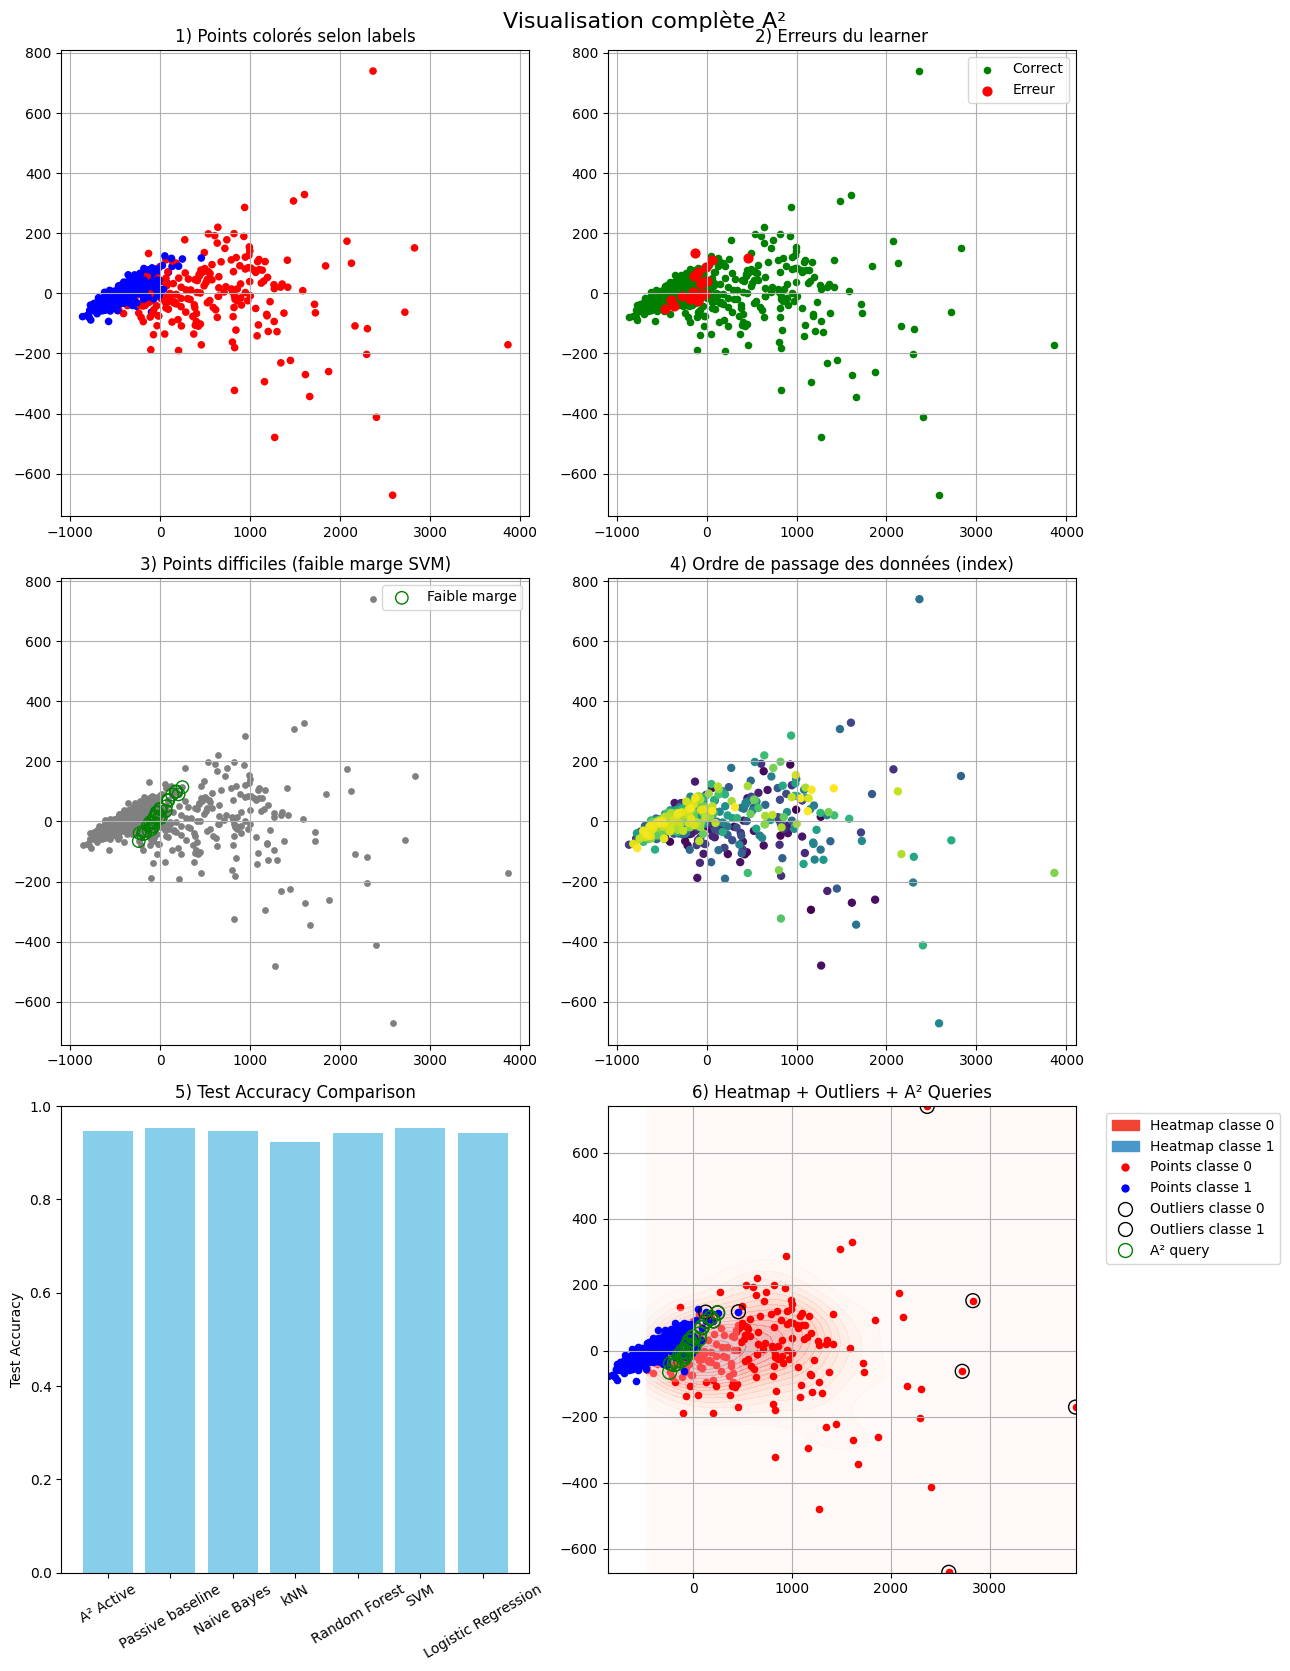


--- Running experiment on Wine ---
Point 50: inférés 6, oracle 44


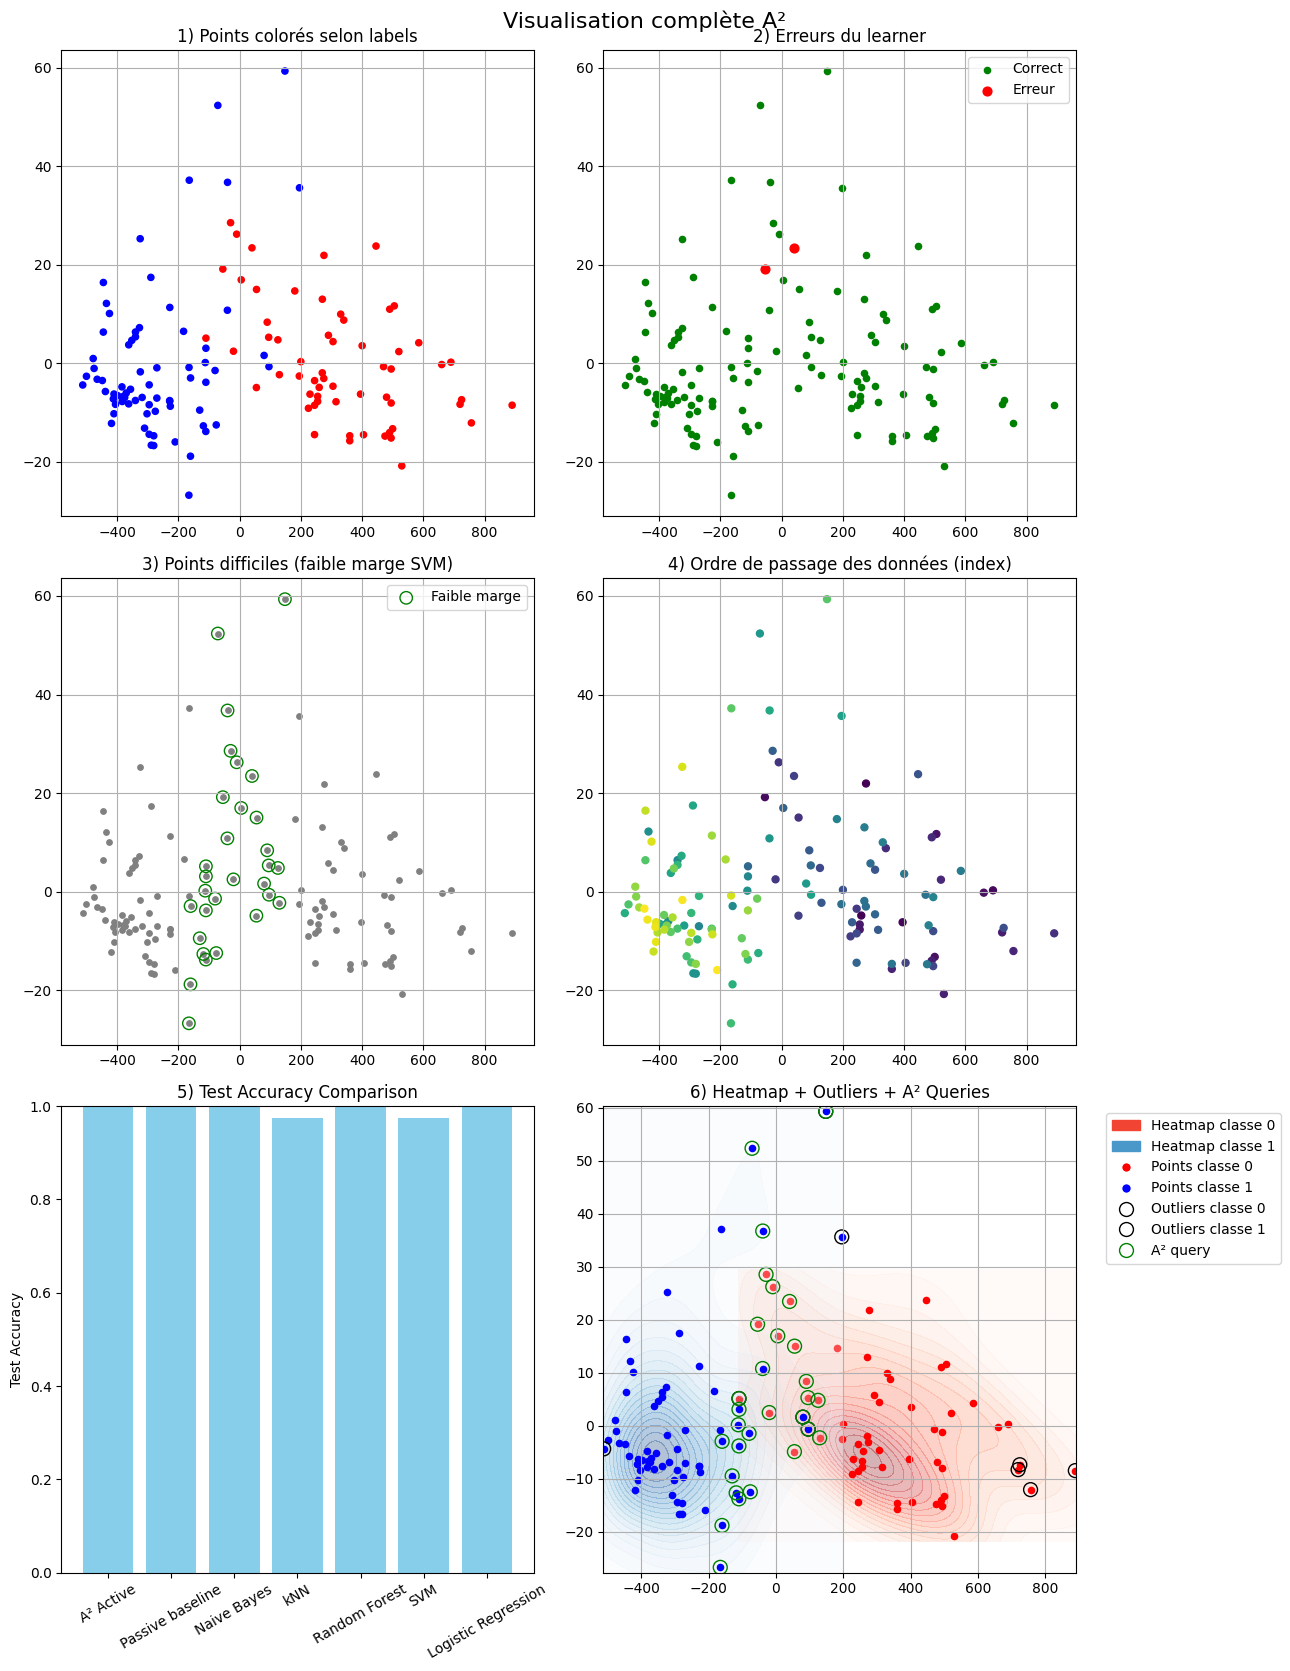

In [17]:
import pandas as pd

# ----------------------------
# 1) Exécuter les expériences sur tous les datasets
# ----------------------------
generated_results = []

for ds in datasets:
    name = ds["name"]
    X, y = ds["X"], ds["y"]
    print(f"\n--- Running experiment on {name} ---")
    
    res = run_experiment(X, y, test_size=0.3, stream_seed=3)
    
    generated_results.append({"dataset": name, **res})


In [18]:
# ----------------------------
# 2) Créer un DataFrame récapitulatif
# ----------------------------
results_df = pd.DataFrame([
    {
        "dataset": r["dataset"],
        "acc_active": r["metrics_active"]["accuracy"],
        "acc_passive": r["metrics_passive"]["accuracy"],
        "queries": r["queries"]
    }
    for r in generated_results
])

print("\n\nResults summary:")
print(results_df.to_string(index=False))




Results summary:
     dataset  acc_active  acc_passive  queries
        Easy    1.000000     1.000000      386
      Medium    0.905556     0.955556      298
        Hard    0.800000     0.916667      220
       Noisy    0.527778     0.811111      182
   Separated    0.972222     1.000000      395
BreastCancer    0.947368     0.953216      312
        Wine    1.000000     1.000000       62


In [19]:
# ----------------------------
# 3) Détails par dataset
# ----------------------------
for r in generated_results:
    print(f"\nDataset: {r['dataset']}")
    
    # Metrics actif
    metrics_a = r['metrics_active']
    print(f"A² Active — Accuracy: {metrics_a['accuracy']:.3f}, Recall: {metrics_a['recall']:.3f}, F1: {metrics_a['f1']:.3f}")
    
    # Metrics passif (meilleur)
    metrics_p = r['metrics_passive']
    print(f"Max Passive ({r['best_passive']}) — Accuracy: {metrics_p['accuracy']:.3f}, Recall: {metrics_p['recall']:.3f}, F1: {metrics_p['f1']:.3f}")
    
    # Nombre de requêtes
    print(f"Number of queries: {r['queries']}")
    
    # Détails autres classifieurs passifs
    print("Other passive classifiers:")
    for clf_name, metrics in r['passive_classifiers'].items():
        print(f"  {clf_name} — Accuracy: {metrics['accuracy']:.3f}, Recall: {metrics['recall']:.3f}, F1: {metrics['f1']:.3f}")



Dataset: Easy
A² Active — Accuracy: 1.000, Recall: 1.000, F1: 1.000
Max Passive (kNN) — Accuracy: 1.000, Recall: 1.000, F1: 1.000
Number of queries: 386
Other passive classifiers:
  Naive Bayes — Accuracy: 0.983, Recall: 0.989, F1: 0.983
  kNN — Accuracy: 1.000, Recall: 1.000, F1: 1.000
  Random Forest — Accuracy: 1.000, Recall: 1.000, F1: 1.000
  SVM — Accuracy: 0.994, Recall: 1.000, F1: 0.994
  Logistic Regression — Accuracy: 1.000, Recall: 1.000, F1: 1.000

Dataset: Medium
A² Active — Accuracy: 0.906, Recall: 0.879, F1: 0.904
Max Passive (kNN) — Accuracy: 0.956, Recall: 0.945, F1: 0.956
Number of queries: 298
Other passive classifiers:
  Naive Bayes — Accuracy: 0.906, Recall: 0.901, F1: 0.906
  kNN — Accuracy: 0.956, Recall: 0.945, F1: 0.956
  Random Forest — Accuracy: 0.939, Recall: 0.923, F1: 0.939
  SVM — Accuracy: 0.889, Recall: 0.857, F1: 0.886
  Logistic Regression — Accuracy: 0.894, Recall: 0.868, F1: 0.893

Dataset: Hard
A² Active — Accuracy: 0.800, Recall: 0.742, F1: 0.793

# Maintentant analysons : 

## Graphe 1 : Accuracy Active A² vs Passive Baseline

Objectif : montrer si A² améliore le classifieur passif en utilisant moins de labels.

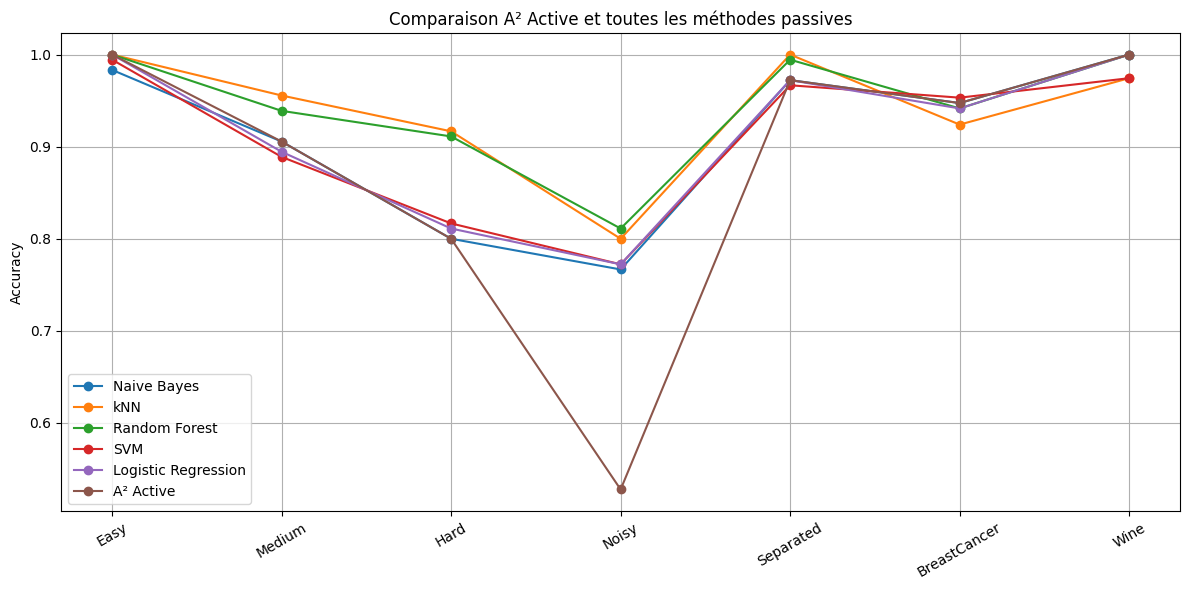

In [24]:
import matplotlib.pyplot as plt

# Récupérer les noms de tous les datasets et résultats
datasets = [r['dataset'] for r in generated_results]
all_results = generated_results

# Récupérer les noms des classifieurs passifs
passive_clf_names = list(all_results[0]['passive_classifiers'].keys())
all_clf_names = passive_clf_names + ["A² Active"]

# Construire les listes d'accuracies pour chaque classifieur
accuracy_dict = {clf_name: [] for clf_name in all_clf_names}

for r in all_results:
    # accuracies passives
    for clf_name in passive_clf_names:
        accuracy_dict[clf_name].append(r['passive_classifiers'][clf_name]['accuracy'])
    # accuracy A² Active
    accuracy_dict["A² Active"].append(r['metrics_active']['accuracy'])

# Tracé
plt.figure(figsize=(12, 6))
for clf_name, acc_list in accuracy_dict.items():
    plt.plot(datasets, acc_list, marker='o', label=clf_name)

plt.ylabel("Accuracy")
plt.title("Comparaison A² Active et toutes les méthodes passives")
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2) Graphe 2 : Nombre de requêtes A² par dataset

Objectif : illustrer le coût en requêtes (labels demandés).

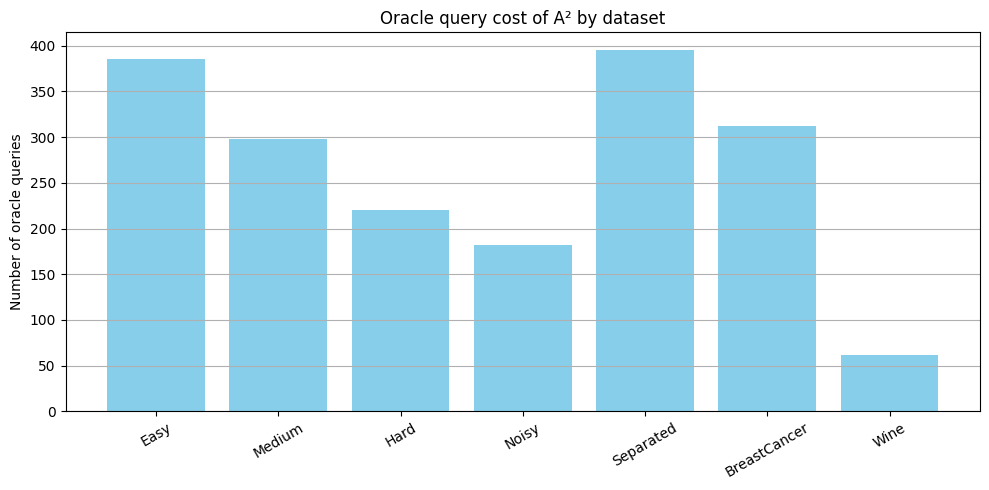

In [25]:
queries = results_df["queries"].tolist()
datasets = results_df["dataset"].tolist()

plt.figure(figsize=(10, 5))
plt.bar(datasets, queries, color='skyblue')
plt.ylabel("Number of oracle queries")
plt.title("Oracle query cost of A² by dataset")
plt.grid(axis='y')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Graphe 3 : Accuracy des classifieurs passifs (comparatif multi-modèles)

Objectif : montrer que les méthodes passives sophistiquées (RF, SVM, kNN) font souvent mieux qu’A².
Cela appuie la conclusion : A² n’est pas destiné à battre les meilleurs classifieurs passifs.

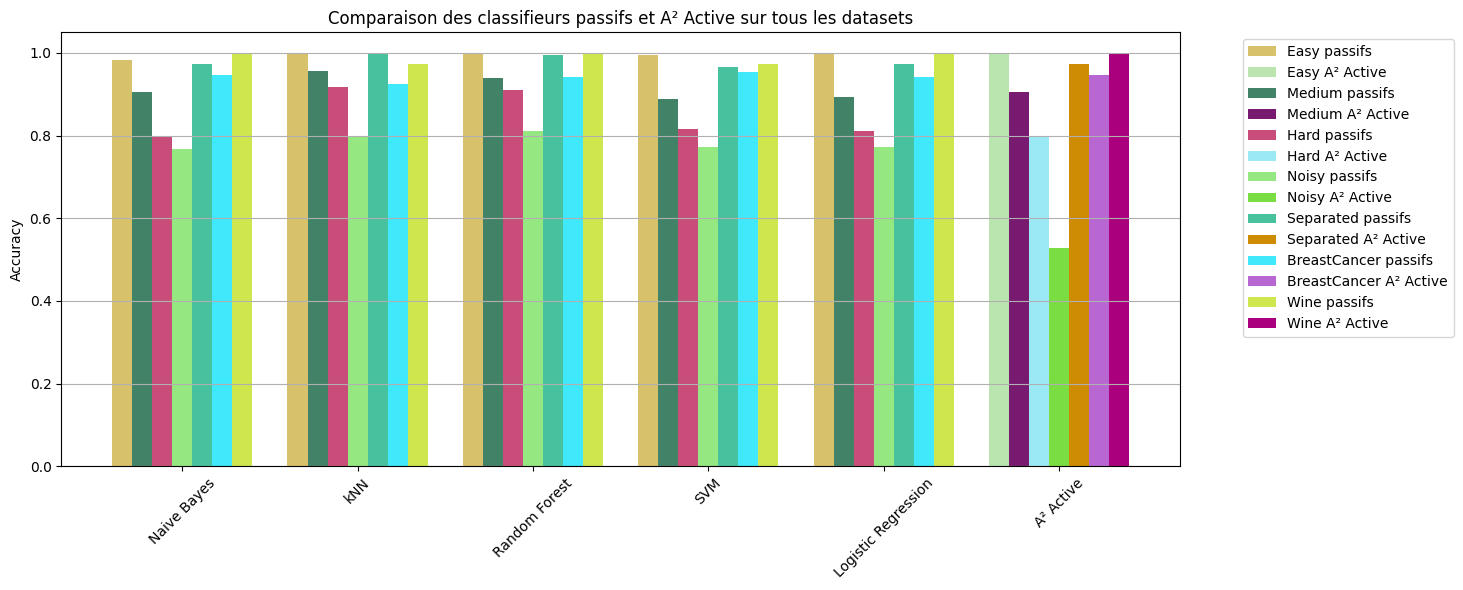

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Patch

# Liste des datasets et résultats
datasets = [r["dataset"] for r in generated_results]
all_results = [r for r in generated_results]

# Noms des classifieurs passifs (on prend ceux du premier dataset)
passive_clf_names = list(all_results[0]['passive_classifiers'].keys())
clf_names = passive_clf_names + ["A² Active"]
n_clfs = len(clf_names)

x = np.arange(n_clfs)
width = 0.8 / len(datasets)  # largeur des barres adaptée au nombre de datasets

plt.figure(figsize=(max(12, n_clfs*1.2), 6))

# Génération de couleurs aléatoires
def random_color():
    return (random.random(), random.random(), random.random())

dataset_colors = [random_color() for _ in datasets]  # pour passifs
a2_colors = [random_color() for _ in datasets]       # pour A² Active

# Plot des barres pour chaque dataset
for i, (dataset_name, res) in enumerate(zip(datasets, all_results)):
    accs = [res['passive_classifiers'][clf]['accuracy'] for clf in passive_clf_names] + [res['metrics_active']['accuracy']]
    colors = [dataset_colors[i]]*len(passive_clf_names) + [a2_colors[i]]
    plt.bar(x + i*width, accs, width, color=colors)

plt.xticks(x + width*(len(datasets)-1)/2, clf_names, rotation=45)
plt.ylabel("Accuracy")
plt.title("Comparaison des classifieurs passifs et A² Active sur tous les datasets")
plt.grid(axis="y")
plt.tight_layout()

# Création de la légende personnalisée
legend_elements = []
for i, dataset_name in enumerate(datasets):
    legend_elements.append(Patch(facecolor=dataset_colors[i], label=f"{dataset_name} passifs"))
    legend_elements.append(Patch(facecolor=a2_colors[i], label=f"{dataset_name} A² Active"))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()
